<div align="center">
 <b>HOMEWORK</b>
</div>
The goal of this homework is to create a regression model for predicting the final_prices (column 'Final Price').

In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv')

In [2]:
# Preparing the dataset
# First, we'll normalize the names of the columns:

df.columns = df.columns.str.lower().str.replace(' ', '_')
# Now, instead of 'Final Price', we have 'final_price'.


In [3]:
#Next, use only the following columns: 'ram', 'storage', 'screen', 'final_price'
df = df[['ram', 'storage', 'screen', 'final_price']]


<Axes: xlabel='final_price', ylabel='Count'>

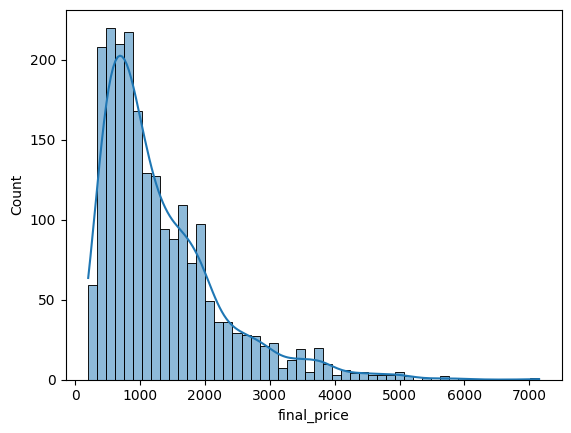

In [4]:
# EDA
# Look at the final_price variable. Does it have a long tail?

# plot the long tail if exists
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.histplot(df['final_price'], bins=50, kde=True)

# YES, it has a long tail

##### Question 1
##### There's one column with missing values. What is it?

In [5]:
missing = df.isnull().sum()
missing = missing[missing > 0]
print(f'The column with missing values is: {missing[missing > 0].index[0]}')


The column with missing values is: screen


##### Question 2
What's the median (50% percentile) for variable 'ram'?

In [6]:
median_ram = df['ram'].median()
print(f'The median for variable ram is: {median_ram}')

The median for variable ram is: 16.0


##### Prepare and split the dataset´
Shuffle the dataset (the filtered one you created above), use seed 42. \
Split your data in train/val/test sets, with 60%/20%/20% distribution. \
Use the same code as in the lectures


In [7]:
import numpy as np

# find the length of the dataset
n = len(df)

# determine the size of each dataset
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [8]:
# shuffle the dataset
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]


In [9]:
# reset the index of the datasets
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
# Applying the log transformation to the target variable

y_train = np.log1p(df_train['final_price'].values)
y_val = np.log1p(df_val['final_price'].values)
y_test = np.log1p(df_test['final_price'].values)

In [11]:
# Deleting the target variable from the datasets

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

##### Question 3
We need to deal with missing values for the column from Q1. \
We have two options: fill it with 0 or with the mean of this variable. \
Try both options. For each, train a linear regression model without regularization using the code from the lessons. \
For computing the mean, use the training only! \
Use the validation dataset to evaluate the models and compare the RMSE of each option. \
Round the RMSE scores to 2 decimal digits using round(score, 2) \
Which option gives better RMSE?

In [12]:
# Functions

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

base = [
    'ram',
    'storage',
    'screen'
]

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

##### 1st option / fill with 0

In [13]:
# Let's fill it with 0
df_train1 = df_train
df_train1['screen'] = df_train1['screen'].fillna(0)
df_train1 = df_train1.values # convert to numpy array

w0, w = train_linear_regression(df_train1, y_train)


In [14]:
y_pred1 = w0 + df_train1.dot(w)

<Axes: ylabel='Count'>

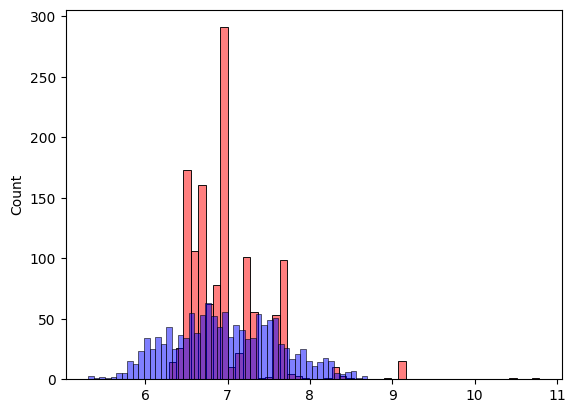

In [15]:
sns.histplot(y_pred1, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [16]:
round(rmse(y_train, y_pred1),2)

np.float64(0.45)

In [17]:
X_val = prepare_X(df_val)
y_pred11 = w0 + X_val.dot(w)
round(rmse(y_val, y_pred11),2)

np.float64(0.43)

##### 2st option / fill with the mean

In [18]:
# Let's fill it with the mean
df_train2 = df_train
df_train2['screen'] = df_train2['screen'].fillna(df_train2['screen'].mean())
df_train2 = df_train2.values # convert to numpy array

In [19]:
w0_2, w2 = train_linear_regression(df_train2, y_train)
y_pred2 = w0_2 + df_train2.dot(w2)

<Axes: ylabel='Count'>

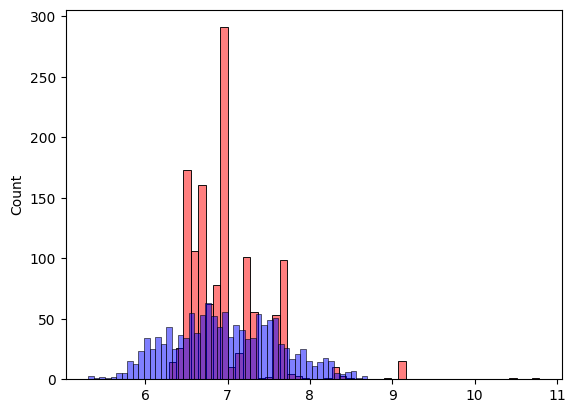

In [20]:
sns.histplot(y_pred2, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [21]:
round(rmse(y_train, y_pred2),2)

np.float64(0.45)

In [22]:
X_val = prepare_X(df_val)
y_pred22 = w0 + X_val.dot(w)
round(rmse(y_val, y_pred22),2)

np.float64(0.43)

Answer: The RMSE of the model with the mean is the same for screen = 0 and screen = mean

#### Question 4
Now let's train a regularized linear regression. \
For this question, fill the NAs with 0. \
Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100]. \
Use RMSE to evaluate the model on the validation dataset. \
Round the RMSE scores to 2 decimal digits. \
Which r gives the best RMSE? \
If there are multiple options, select the smallest r.

In [23]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [24]:
df_train3 = df_train
best_r = None
best_rmse = float('inf')

for r in [0, 0.01, 1, 10, 100]:
    X_train3 = prepare_X(df_train3)
    w0_3, w_3 = train_linear_regression_reg(X_train3, y_train, r=r)

    X_val_3 = prepare_X(df_val)
    y_pred_3 = w0_3 + X_val_3.dot(w_3)
    current_rmse = round(rmse(y_val, y_pred_3), 2)

    print(f'When r = {r}, the RMSE is {current_rmse}')

    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_r = r

print(f'\nThe best r is {best_r} with RMSE {best_rmse}')

When r = 0, the RMSE is 0.43
When r = 0.01, the RMSE is 0.43
When r = 1, the RMSE is 0.43
When r = 10, the RMSE is 0.51
When r = 100, the RMSE is 0.67

The best r is 0 with RMSE 0.43


#### Question 5
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score. \
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]. \
For each seed, do the train/validation/test split with 60%/20%/20% distribution. \
Fill the missing values with 0 and train a model without regularization. \
For each seed, evaluate the model on the validation dataset and collect the RMSE scores. \
What's the standard deviation of all the scores? To compute the standard deviation, use np.std. \
Round the result to 3 decimal digits (round(std, 3))

In [25]:
rmse_scores = []

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    np.random.seed(s)
    np.random.shuffle(idx)

    df_train5 = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val5 = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test5 = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

    y_train5 = df_train5.final_price.values
    y_val5 = df_val5.final_price.values
    y_test5 = df_test5.final_price.values

    del df_train5['final_price']
    del df_val5['final_price']
    del df_test5['final_price']

    # train
    X_train5 = prepare_X(df_train5)
    w0_5, w5 = train_linear_regression(X_train5, y_train5)

    # validate
    X_val5 = prepare_X(df_val5)
    y_pred5 = w0_5 + X_val5.dot(w5)


    # rmse
    score = round(rmse(y_val5, y_pred5),2)
    rmse_scores.append(score)

    print('Seed= {} , Rmse score = {}'.format(s,score))

Seed= 0 , Rmse score = 650.09
Seed= 1 , Rmse score = 610.85
Seed= 2 , Rmse score = 554.12
Seed= 3 , Rmse score = 584.52
Seed= 4 , Rmse score = 582.52
Seed= 5 , Rmse score = 623.52
Seed= 6 , Rmse score = 608.45
Seed= 7 , Rmse score = 563.1
Seed= 8 , Rmse score = 574.91
Seed= 9 , Rmse score = 591.61


In [26]:
# what is the standard deviation of all the scores?
print('The standard deviation of all the scores is: ', round(np.std(rmse_scores), 3))

The standard deviation of all the scores is:  27.651


#### Question 6
Split the dataset like previously, use seed 9. \
Combine train and validation datasets. \
Fill the missing values with 0 and train a model with r=0.001. \
What's the RMSE on the test dataset?

In [34]:
np.random.seed(9)
np.random.shuffle(idx)

df_train6 = df.iloc[idx[:n_train]]
df_val6 = df.iloc[idx[n_train:n_train+n_val]]
df_test6 = df.iloc[idx[n_train+n_val:]]

y_train6 = df_train6['final_price'].values
y_val6 = df_val6['final_price'].values
y_test6 = df_test6['final_price'].values

# y_train6 = np.log1p(df_train6['final_price'].values)
# y_val6 = np.log1p(df_val6['final_price'].values)
# y_test6 = np.log1p(df_test6['final_price'].values)

del df_train6['final_price']
del df_val6['final_price']
del df_test6['final_price']

# combine tran and val datasets
df_full_train = pd.concat([df_train6, df_val6])
df_full_train = df_full_train.reset_index(drop=True)
X_full_train = prepare_X(df_full_train)

y_full_train = np.concatenate([y_train, y_val])



In [35]:
w0_6, w6 = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [37]:
X_test6 = prepare_X(df_test6)
y_pred6 = w0_6 + X_test6.dot(w6)
score = round(rmse(y_test6, y_pred6),2)
print('The RMSE score for the test dataset is: ', score)

The RMSE score for the test dataset is:  1655.1


In [ ]:
# Didn't get the same result as the solution to last RMSE